# CNN

https://thejaskiran99.medium.com/unlocking-the-potential-of-convolutional-neural-networks-cnns-in-time-series-forecasting-b2fac329e184#:~:text=Convolutional%20Neural%20Networks%20have%20evolved,the%20time%20series%20forecasting%20toolkit.

Attention ordre des colonnes dans le dataframe : la conso n'est pas à la fin !!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D ,Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense
from utils import *
from joblib import load


Other way ---------------------------------------------------------------------

In [2]:
df = pd.read_csv('consumption_and_temperatures.csv')


#Select the area that you want to study
area = 1
test_set_days = 10

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing(df, area = area, test_set_days = test_set_days)

In [3]:
X_train.columns

Index(['NO1_temperature', 'NO1_consumption_24h_before',
       'NO1_consumption_avg_prev_day', 'month', 'day', 'hour'],
      dtype='object')

## Sequence Data Creation

In [8]:
#Add first the target as it is necessary in forecasting with sequential data
X_train[f'NO{area}_consumption'] = y_train
X_val[f'NO{area}_consumption'] = y_val
X_test[f'NO{area}_consumption'] = y_test

n_features = X_train.shape[1]

train_data_series = X_train.values.reshape(len(X_train), n_features)
train_target_series = y_train.values.reshape((len(y_train), 1))
val_data_series = X_val.values.reshape(len(X_val), n_features)
val_target_series = y_val.values.reshape((len(y_val), 1))
test_data_series = X_test.values.reshape(len(X_test), n_features)
test_target_series  = y_test.values.reshape((len(y_test), 1))

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

look_back = 72

train_generator = TimeseriesGenerator(train_data_series, train_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)

val_generator = TimeseriesGenerator(train_data_series, train_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)

test_generator = TimeseriesGenerator(test_data_series, test_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)




In [10]:

def create_sequences(data):

    X_series = []
    y_series = []
    for i in range(len(data)):
        X, y = data[i]
        X_series.append(X)
        y_series.append(y)

    return np.array(X_series), np.array(y_series)



X_train_seq, y_train_seq = create_sequences(train_generator)
X_val_seq, y_val_seq = create_sequences(val_generator)
X_test_seq, y_test_seq = create_sequences(test_generator)

# Reshape the input data for the CNN
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[2], n_features)
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[2], n_features)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[2], n_features)

## Model Training

In [11]:
from keras.callbacks import Callback

# Définir le callback pour enregistrer la perte après chaque batch
class BatchLossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []

    def on_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))

# Initialiser le callback
batch_loss_history = BatchLossHistory()

c:\Users\vadim\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/5
2919/2919 - 20s - 7ms/step - loss: 0.0514 - val_loss: 0.0360
Epoch 2/5
2919/2919 - 17s - 6ms/step - loss: 0.0359 - val_loss: 0.0307
Epoch 3/5
2919/2919 - 16s - 6ms/step - loss: 0.0298 - val_loss: 0.0243
Epoch 4/5
2919/2919 - 16s - 5ms/step - loss: 0.0245 - val_loss: 0.0232
Epoch 5/5
2919/2919 - 16s - 6ms/step - loss: 0.0218 - val_loss: 0.0199


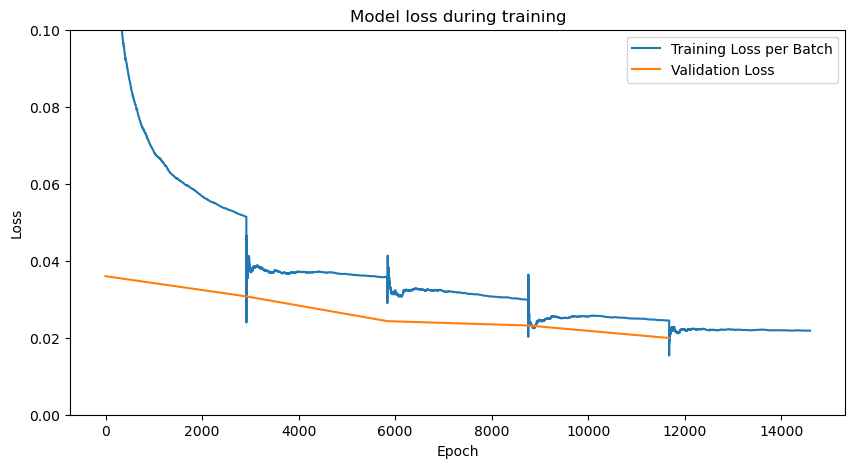

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [12]:
# Create a CNN model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back, n_features,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Output layer for regression

# Compile the model
# Mean Squared Error for regression
model.compile(optimizer='adam', loss='mse') 

epochs = 5

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=epochs, batch_size=16, validation_data=(X_val_seq, y_val_seq), verbose=2, callbacks=[batch_loss_history])
# Tracer la perte du training set et du validation set

# Nombre de batches par époque (approximation)
batches_per_epoch = len(batch_loss_history.batch_losses) / len(history.history['val_loss'])
plt.figure(figsize=(10, 5))
plt.plot(batch_loss_history.batch_losses, label='Training Loss per Batch')
plt.plot([i*batches_per_epoch for i in range(epochs)],history.history['val_loss'], label='Validation Loss')
plt.title('Model loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

# Make predictions
y_pred = model.predict(X_test_seq)



## First Quick Viz

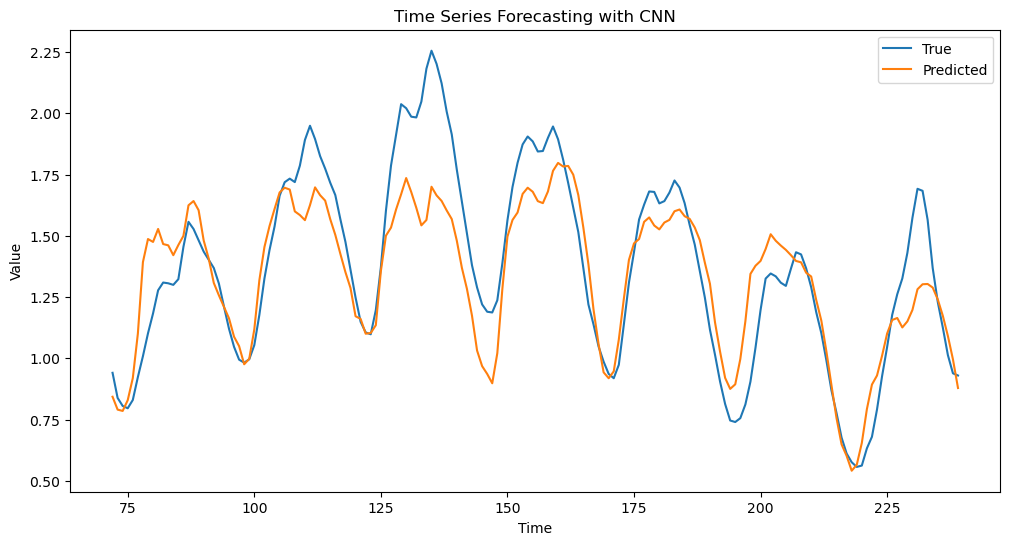

In [13]:
# Plot the original and predicted time series
plt.figure(figsize=(12, 6))
plt.plot(X_test.index[look_back:], np.squeeze(y_test_seq), label='True')
plt.plot(X_test.index[look_back:], np.squeeze(y_pred), 
label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Forecasting with CNN')
plt.show()

In [14]:
extrapolation = list()
seed_batch = X_test_seq[0].reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(len(X_test)-look_back):
    predicted_value = model.predict(current_batch)[0]
    print(f'predicted value = {predicted_value} ; target = {X_test.iloc[look_back+i, n_features-1]}')
    extrapolation.append(predicted_value)
    next_step = np.append(X_test.iloc[look_back + i,:n_features-1],[predicted_value])
    current_batch = np.append(current_batch[:,1:,:],[[next_step]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted value = [0.8432762] ; target = 0.940983542465685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
predicted value = [0.7908089] ; target = 0.8384988981864381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted value = [0.78540885] ; target = 0.8058039913012971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
predicted value = [0.8294106] ; target = 0.7963107479684518
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted value = [0.9193343] ; target = 0.8300128639169915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
predicted value = [1.1009046] ; target = 0.9234182089762445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted value = [1.3927145] ; target = 1.0087733791899158
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted value = [1.4867646] ; target = 1.1020560608115855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
predicted value = [1.4749478] ; target = 1.1834063636979355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted value = [1.5279135] ; target = 1.277711984652473
1/1 ━━━━━━━━━━━━━━━━

Text(0.5, 1.0, 'Consumption Forecast for 24 time step')

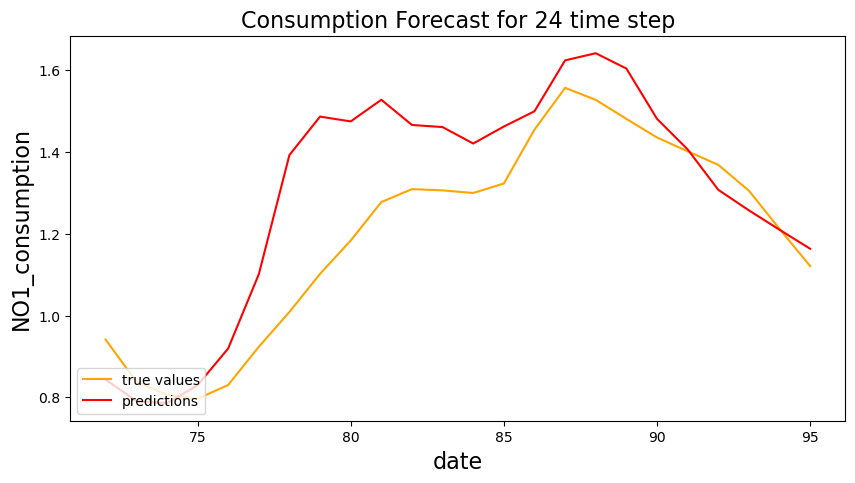

In [15]:
window = 96

plt.figure(figsize=(10,5))
plt.plot(X_test.index[look_back:window], X_test[f'NO{area}_consumption'][look_back:window], c='orange',label='true values')
plt.plot(X_test.index[look_back:window],extrapolation[:24], c='r',linestyle = '-', label='predictions')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel(f"NO{area}_consumption", fontsize=16)
plt.title("Consumption Forecast for 24 time step", fontsize=16)

## Model Evaluation

In [16]:
target = []
output = []
subsets = 7
# Calculez la taille de chaque sous-ensemble
subset_size = len(X_test_seq) // subsets



for j in range(subsets):

    extrapolation = list()
    seed_batch = X_test_seq[0+j*subset_size].reshape((1,look_back, n_features))
    current_batch = seed_batch

    for i in range(subset_size):
        predicted_value = model.predict(current_batch)[0]
        extrapolation.append(predicted_value)
        next_step = np.append(X_test.iloc[look_back + i + j*subset_size,:n_features-1],[predicted_value])
        current_batch = np.append(current_batch[:,1:,:],[[next_step]],axis=1)

    
    extrapolation_list = [item[0] for item in extrapolation]
    output.append(extrapolation_list)
    target.append(X_test[f'NO{area}_consumption'][look_back + j*subset_size : look_back + (j+1)*subset_size])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

### Back to original scale

In [17]:
#Get the scaler trained on the data to do the inverse trnsformation

scaler = load('scaler.joblib') 

features = ['NO1_consumption', 'NO1_temperature', 'NO2_consumption', 'NO2_temperature', 'NO3_consumption', 'NO3_temperature', 'NO4_consumption', 'NO4_temperature', 'NO5_consumption', 
            'NO5_temperature', 'month', 'day', 'hour', 'NO1_consumption_avg_prev_day', 'NO2_consumption_avg_prev_day', 'NO3_consumption_avg_prev_day', 'NO4_consumption_avg_prev_day', 'NO5_consumption_avg_prev_day']

# Crée un dictionnaire vide
features_stats = {}

# Remplir le dictionnaire avec les noms de features comme clés et des tuples (moyenne, écart type) comme valeurs
for i, feature in enumerate(features):
    features_stats[feature] = (scaler.mean_[i], scaler.scale_[i])

# Afficher le dictionnaire
print(features_stats)

{'NO1_consumption': (3981.0436009012637, 1322.5456843142601), 'NO1_temperature': (7.764708900814608, 8.247860610260771), 'NO2_consumption': (4169.7763540568085, 722.3703449646478), 'NO2_temperature': (8.695760193282162, 5.933965242221361), 'NO3_consumption': (3078.0098907762713, 479.62795876368966), 'NO3_temperature': (6.471469500331401, 7.793164353262397), 'NO4_consumption': (2158.026760123517, 358.95717035620817), 'NO4_temperature': (3.5041457313292423, 6.721843042860674), 'NO5_consumption': (1896.8621299586496, 307.15345928067035), 'NO5_temperature': (8.834070257210664, 6.102418963148515), 'month': (6.5221611682452805, 3.349962447655115), 'day': (15.735669538816788, 8.803396994727473), 'hour': (11.49898441341857, 6.921844135142303), 'NO1_consumption_avg_prev_day': (3981.477302283471, 1253.1522860429614), 'NO2_consumption_avg_prev_day': (4169.884235578063, 680.2662590450351), 'NO3_consumption_avg_prev_day': (3077.9182458301084, 452.676204918579), 'NO4_consumption_avg_prev_day': (2158

In [18]:
# Instancier un nouveau StandardScaler
scaler_invert = StandardScaler()

# Définir manuellement les moyennes et écarts types pour ce nouveau scaler
scaler_invert.mean_ = features_stats[f'NO{area}_consumption'][0]
scaler_invert.scale_ = features_stats[f'NO{area}_consumption'][1]

In [19]:
X_test = scaler_invert.inverse_transform(X_test)

X_test = pd.DataFrame(X_test, columns=X_train.columns)

output = scaler_invert.inverse_transform(output)

target = scaler_invert.inverse_transform(target)

### Viz

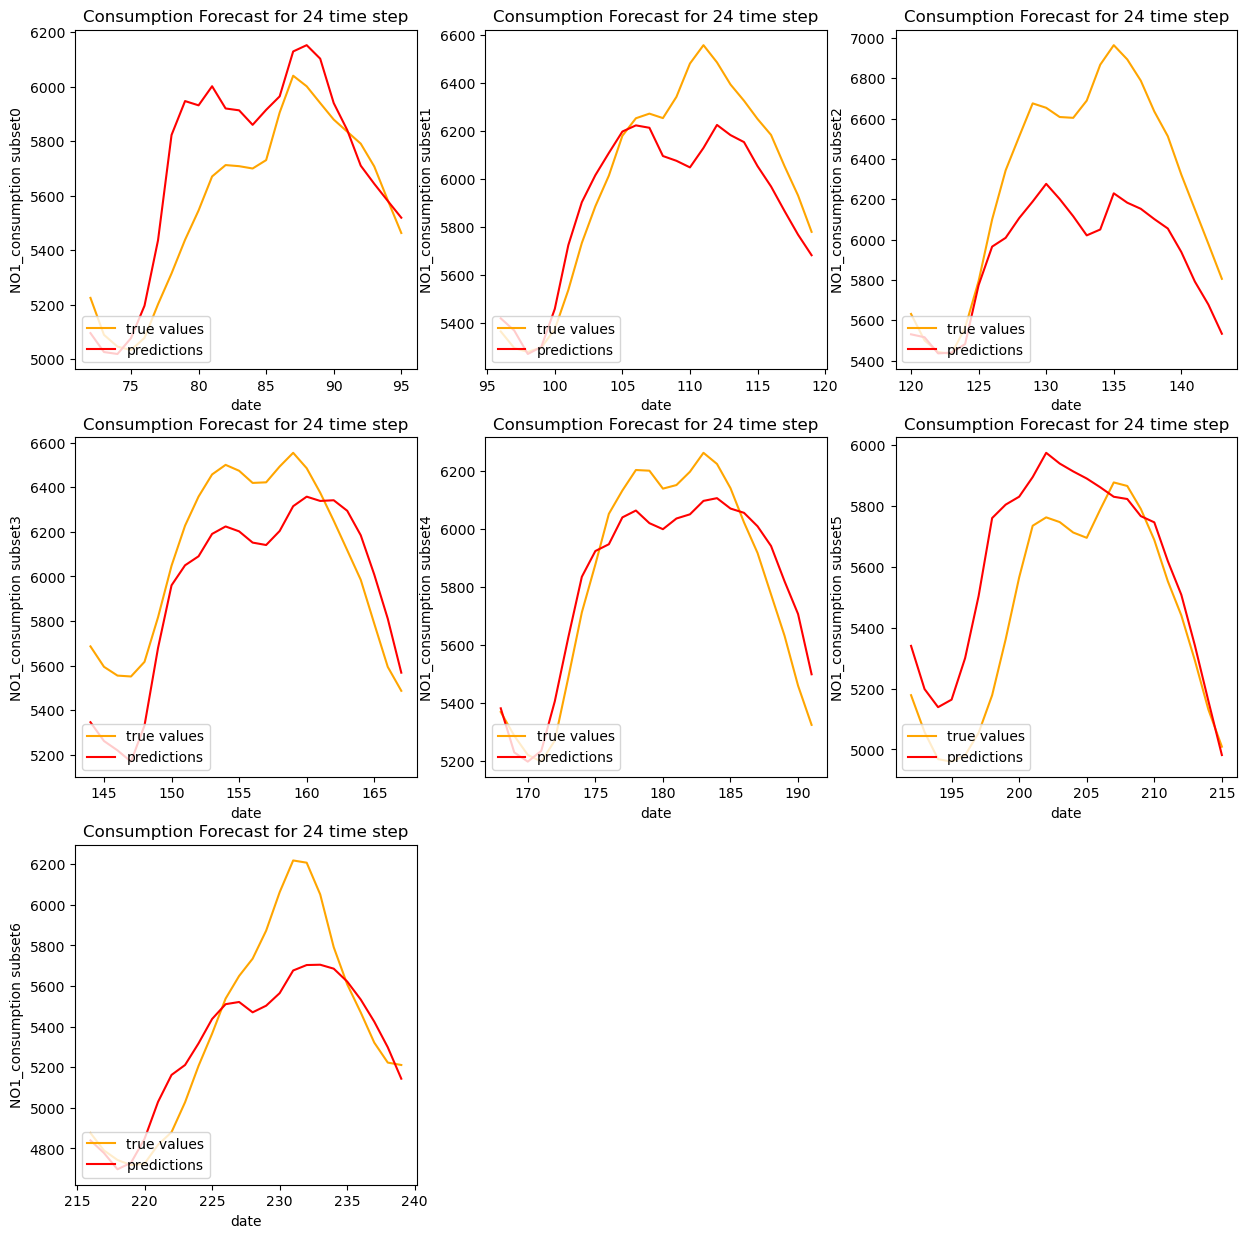

In [20]:
plt.figure(figsize=(15,15))

for j in range(subsets):
    plt.subplot(3, 3, j + 1)
    plt.plot(X_test.index[look_back + j*subset_size : look_back + (j+1)*subset_size], X_test[f'NO{area}_consumption'][look_back + j*subset_size : look_back + (j+1)*subset_size], c='orange',label='true values')
    plt.plot(X_test.index[look_back + j*subset_size : look_back + (j+1)*subset_size],output[j], c='r',linestyle = '-', label='predictions')
    plt.legend(loc="lower left")
    plt.xlabel("date")
    plt.ylabel(f"NO{area}_consumption subset{j}")
    plt.title("Consumption Forecast for 24 time step")

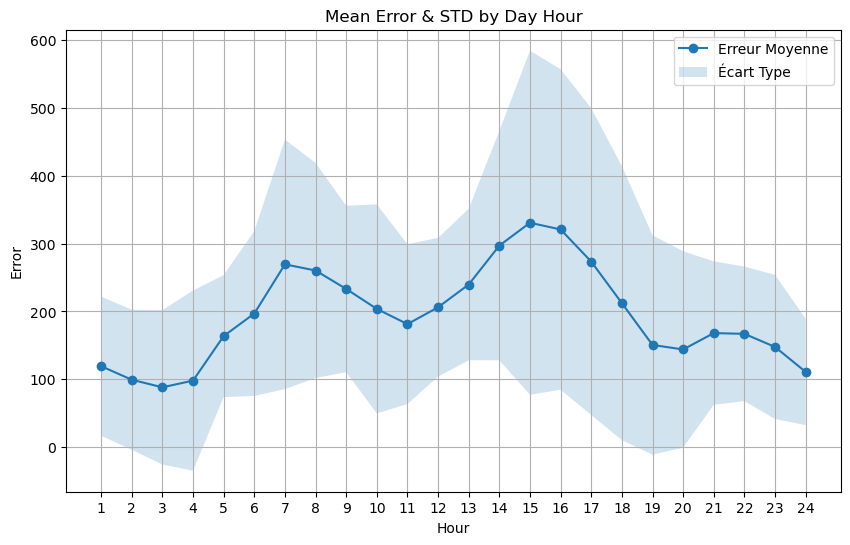

Global Mean Error for CNN = 4683.658347507612


In [21]:
error = abs(target - output)

erreur_moyenne = np.mean(error, axis=0)
ecart_type = np.std(error, axis=0)
heures = np.arange(1, 25)  # De 1 à 24 heures

plt.figure(figsize=(10, 6))

# Tracer l'erreur moyenne
plt.plot(heures, erreur_moyenne, label='Erreur Moyenne', marker='o')
plt.fill_between(heures, erreur_moyenne - ecart_type, erreur_moyenne + ecart_type, alpha=0.2, label='Écart Type')
plt.title('Mean Error & STD by Day Hour')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.xticks(heures)  
plt.legend()

plt.grid(True)
plt.show()

print(f"Global Mean Error for CNN = {erreur_moyenne.sum()}")


We noticed that prediction is better when window sequence is larger than 24 (here is look_back =72)

## Test with your own Data 

In [22]:
df = pd.read_csv('consumption_and_temperatures.csv')


#Select the area that you want to study
area = 5
test_set_days = 10

X_train, y_train, X_val, y_val, X_test, y_test = preprocessing(df, area = area, test_set_days = test_set_days)

#Add first the target as it is necessary in forecasting with sequential data
X_train[f'NO{area}_consumption'] = y_train
X_val[f'NO{area}_consumption'] = y_val
X_test[f'NO{area}_consumption'] = y_test

n_features = X_train.shape[1]

train_data_series = X_train.values.reshape(len(X_train), n_features)
train_target_series = y_train.values.reshape((len(y_train), 1))
val_data_series = X_val.values.reshape(len(X_val), n_features)
val_target_series = y_val.values.reshape((len(y_val), 1))
test_data_series = X_test.values.reshape(len(X_test), n_features)
test_target_series  = y_test.values.reshape((len(y_test), 1))

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

look_back = 72

train_generator = TimeseriesGenerator(train_data_series, train_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)

val_generator = TimeseriesGenerator(train_data_series, train_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)

test_generator = TimeseriesGenerator(test_data_series, test_target_series,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)

def create_sequences(data):

    X_series = []
    y_series = []
    for i in range(len(data)):
        X, y = data[i]
        X_series.append(X)
        y_series.append(y)

    return np.array(X_series), np.array(y_series)



X_train_seq, y_train_seq = create_sequences(train_generator)
X_val_seq, y_val_seq = create_sequences(val_generator)
X_test_seq, y_test_seq = create_sequences(test_generator)

# Reshape the input data for the CNN
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], X_train_seq.shape[2], n_features)
X_val_seq = X_val_seq.reshape(X_val_seq.shape[0], X_val_seq.shape[2], n_features)
X_test_seq = X_test_seq.reshape(X_test_seq.shape[0], X_test_seq.shape[2], n_features)

In [23]:
y_pred = model.predict(X_test_seq)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [24]:
target = []
output = []
subsets = 7
# Calculez la taille de chaque sous-ensemble
subset_size = len(X_test_seq) // subsets



for j in range(subsets):

    extrapolation = list()
    seed_batch = X_test_seq[0+j*subset_size].reshape((1,look_back, n_features))
    current_batch = seed_batch

    for i in range(subset_size):
        predicted_value = model.predict(current_batch)[0]
        extrapolation.append(predicted_value)
        next_step = np.append(X_test.iloc[look_back + i + j*subset_size,:n_features-1],[predicted_value])
        current_batch = np.append(current_batch[:,1:,:],[[next_step]],axis=1)

    
    extrapolation_list = [item[0] for item in extrapolation]
    output.append(extrapolation_list)
    target.append(X_test[f'NO{area}_consumption'][look_back + j*subset_size : look_back + (j+1)*subset_size])

#Get the scaler trained on the data to do the inverse trnsformation

scaler = load('scaler.joblib') 

features = ['NO1_consumption', 'NO1_temperature', 'NO2_consumption', 'NO2_temperature', 'NO3_consumption', 'NO3_temperature', 'NO4_consumption', 'NO4_temperature', 'NO5_consumption', 
            'NO5_temperature', 'month', 'day', 'hour', 'NO1_consumption_avg_prev_day', 'NO2_consumption_avg_prev_day', 'NO3_consumption_avg_prev_day', 'NO4_consumption_avg_prev_day', 'NO5_consumption_avg_prev_day']

# Crée un dictionnaire vide
features_stats = {}

# Remplir le dictionnaire avec les noms de features comme clés et des tuples (moyenne, écart type) comme valeurs
for i, feature in enumerate(features):
    features_stats[feature] = (scaler.mean_[i], scaler.scale_[i])

# Afficher le dictionnaire
print(features_stats)

# Instancier un nouveau StandardScaler
scaler_invert = StandardScaler()

# Définir manuellement les moyennes et écarts types pour ce nouveau scaler
scaler_invert.mean_ = features_stats[f'NO{area}_consumption'][0]
scaler_invert.scale_ = features_stats[f'NO{area}_consumption'][1]

X_test = scaler_invert.inverse_transform(X_test)

X_test = pd.DataFrame(X_test, columns=X_train.columns)

output = scaler_invert.inverse_transform(output)

target = scaler_invert.inverse_transform(target)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

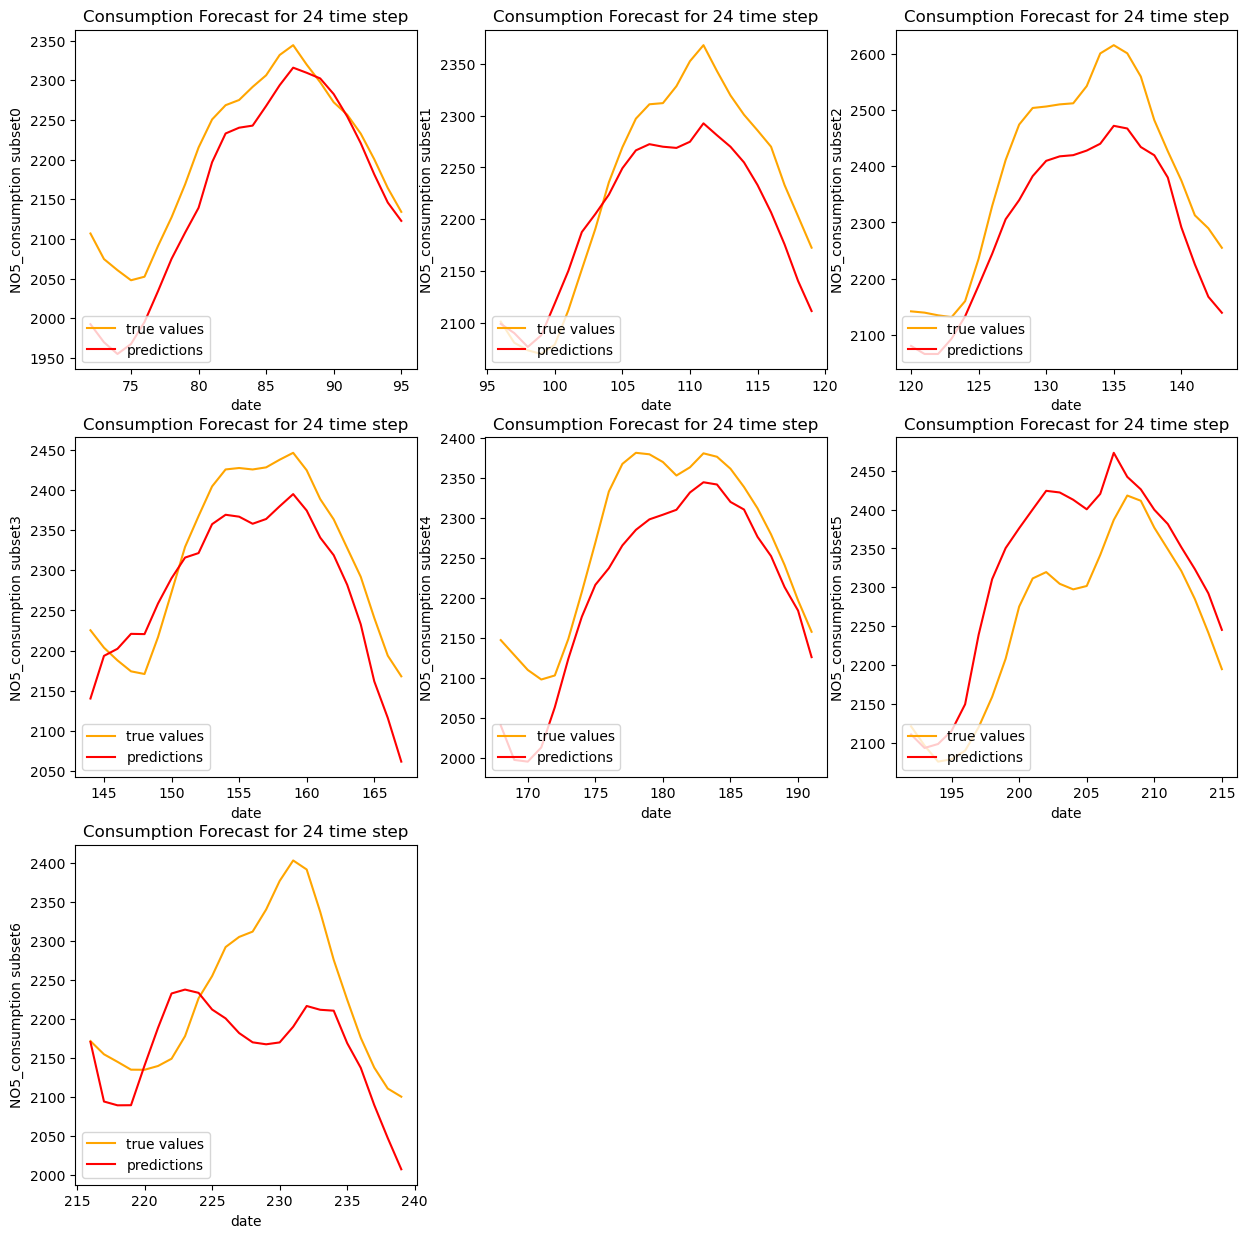

In [25]:
plt.figure(figsize=(15,15))

for j in range(subsets):
    plt.subplot(3, 3, j + 1)
    plt.plot(X_test.index[look_back + j*subset_size : look_back + (j+1)*subset_size], X_test[f'NO{area}_consumption'][look_back + j*subset_size : look_back + (j+1)*subset_size], c='orange',label='true values')
    plt.plot(X_test.index[look_back + j*subset_size : look_back + (j+1)*subset_size],output[j], c='r',linestyle = '-', label='predictions')
    plt.legend(loc="lower left")
    plt.xlabel("date")
    plt.ylabel(f"NO{area}_consumption subset{j}")
    plt.title("Consumption Forecast for 24 time step")

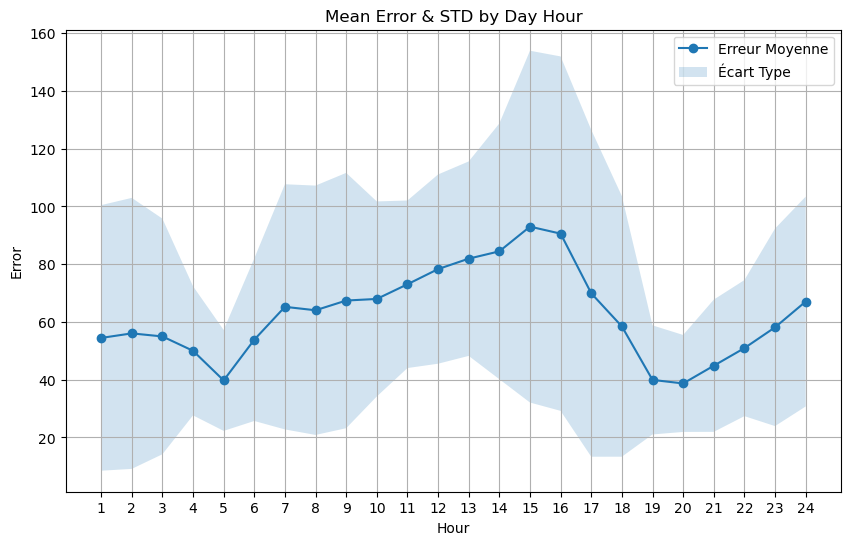

Global Mean Error for CNN = 1503.21725066119


In [26]:
error = abs(target - output)

erreur_moyenne = np.mean(error, axis=0)
ecart_type = np.std(error, axis=0)
heures = np.arange(1, 25)  # De 1 à 24 heures

plt.figure(figsize=(10, 6))

# Tracer l'erreur moyenne
plt.plot(heures, erreur_moyenne, label='Erreur Moyenne', marker='o')
plt.fill_between(heures, erreur_moyenne - ecart_type, erreur_moyenne + ecart_type, alpha=0.2, label='Écart Type')
plt.title('Mean Error & STD by Day Hour')
plt.xlabel('Hour')
plt.ylabel('Error')
plt.xticks(heures)  
plt.legend()

plt.grid(True)
plt.show()

print(f"Global Mean Error for CNN = {erreur_moyenne.sum()}")